In [1]:
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
import random

# from data.data_accessors import tmprss2_to_pandas
import numpy as np
from rdkit import Chem, DataStructs
import matplotlib.pyplot as plt
import pandas as pd
import scipy.stats

from sklearn.svm import LinearSVC
from sklearn.svm import LinearSVR
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV, cross_val_score

import pickle

random.seed(1)

os.chdir('/Users/JacobUmans/tmprss2/notebooks')

In [2]:
# collect dataset
dataset = pd.read_pickle("../dumps/combined_dataset.pkl")
dataset

,acvalue_target,activity_target,target,tmprss2_vs_target_spearman_r,acvalue_scaled_to_tmprss2,cid,morgan_fingerprint
0,0.019,Active,TMPRSS2,1.000000,0.019,46899577,"[0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1,0.019,Active,TMPRSS2,1.000000,0.019,56677005,"[0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
2,0.020,Active,TMPRSS2,1.000000,0.020,49835415,"[0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
3,0.021,Active,TMPRSS2,1.000000,0.021,49835557,"[0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
4,0.044,Active,TMPRSS2,1.000000,0.044,0,"[0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
...,...,...,...,...,...,...,...
890,0.168,Active,TMPRSS11D,0.064941,NaN,49835606,"[0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
891,0.038,Active,TMPRSS11D,0.064941,NaN,56680339,"[0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
892,0.043,Active,TMPRSS11D,0.064941,NaN,56683657,"[0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
893,0.183,Active,TMPRSS11D,0.064941,NaN,56683658,"[0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, ..."


In [3]:
fingerprints = dataset.morgan_fingerprint
X = np.zeros([len(dataset), 2048])
for i in range(len(dataset)):
    for j in range(2048):
        X[i][j] = fingerprints[i][j]

y = np.array(dataset.acvalue_scaled_to_tmprss2)

X = X[~np.isnan(y)]

y = -np.log10(y)
y = y[~np.isnan(y)]

In [4]:
#split training and testing data for each dataset
print(y.shape)
train_X, test_X, train_y, test_y = train_test_split(X, y, test_size=0.2)

(425,)


In [5]:
Cs = np.logspace(-6, -1, 10)
clf = GridSearchCV(estimator=LinearSVR(random_state=0, tol=1e-5), param_grid=dict(C=Cs), n_jobs=-1)
clf.fit(train_X, train_y) 
c_param = clf.best_estimator_.C


/Users/JacobUmans/opt/miniconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


SVR RMSE:0.8491361253734167
(0.6868532420544606, 3.943914661836375e-13)


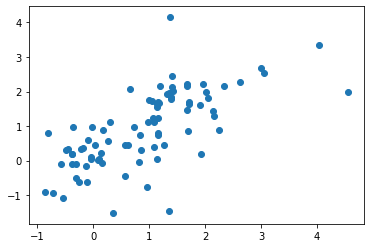

In [6]:
#SVM regression
svmReg = make_pipeline(StandardScaler(), LinearSVR(random_state=0, tol=1e-5, C=c_param))
svmReg.fit(train_X, train_y)

pred = svmReg.predict(test_X)
MSE = mean_squared_error(test_y, pred)
RMSE = np.sqrt(MSE)
print("SVR RMSE:{}".format(RMSE))

plt.scatter(test_y, pred)
corr = scipy.stats.pearsonr(test_y, pred)
print(corr)

In [7]:
# collect dataset
broad_library = pd.read_csv('../data/broad_repurposing_library.csv')
broad_library = broad_library.drop(9603)
broad_library = broad_library.drop(9602)
broad_library = broad_library.drop(9040)
broad_library = broad_library.drop(8416)
broad_library = broad_library.drop(7224)
broad_library = broad_library.drop(2548)
broad_library['fingerprints'] = broad_library.smiles.apply(lambda s: Chem.RDKFingerprint(Chem.MolFromSmiles(s)))


In [8]:
broad_fingerprints = np.zeros([len(broad_library), 2048])
for i in range(len(broad_library)):
    DataStructs.ConvertToNumpyArray(broad_library.fingerprints.iloc[i], broad_fingerprints[i])

In [9]:
Cs = np.logspace(-6, -1, 10)
clf_full = GridSearchCV(estimator=LinearSVR(random_state=0, tol=1e-5), param_grid=dict(C=Cs), n_jobs=-1)
clf_full.fit(X, y) 
c_param_full = clf_full.best_estimator_.C

/Users/JacobUmans/opt/miniconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


In [10]:
svmReg_full = make_pipeline(StandardScaler(), LinearSVR(random_state=0, tol=1e-5, C=c_param_full))
svmReg_full.fit(X, y)
predictions = np.zeros([len(broad_fingerprints), 2])
pred_values = svmReg_full.predict(broad_fingerprints)

In [11]:
argsort = np.argsort(pred_values)
compounds_sorted = broad_library.smiles[argsort]
compounds_names_sorted = broad_library.pert_iname[argsort]
pred_values_sorted = pred_values[argsort]


In [12]:
compounds_names_sorted

3424            EMD-386088
8510             SKF-96365
8509             SKF-91488
8508             SKF-91488
8992             TC-N-1752
               ...        
2948        desoximetasone
1224           bardoxolone
280                  A0001
279                  A0001
1225    bardoxolone-methyl
Name: pert_iname, Length: 10141, dtype: object

In [13]:
pred_values_sorted

array([-25.06687502, -23.88959153, -23.88959153, ...,   6.92089895,
         6.92089895,   7.35350829])

Text(0.5, 1.0, 'SVM Validation Data')

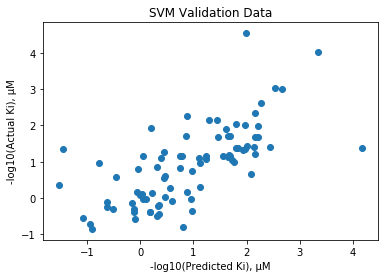

In [14]:
plt.scatter(pred, test_y)
plt.xlabel('-log10(Predicted Ki), μM')
plt.ylabel('-log10(Actual Ki), μM')
plt.title('SVM Validation Data')

(array([ 12.,  60.,  80., 147., 321., 556., 651., 834., 942., 855., 954.,
        992., 872., 846., 702., 643., 404., 247.,  19.,   4.]),
 array([-25.06687502, -23.44585585, -21.82483669, -20.20381752,
        -18.58279835, -16.96177919, -15.34076002, -13.71974086,
        -12.09872169, -10.47770253,  -8.85668336,  -7.2356642 ,
         -5.61464503,  -3.99362586,  -2.3726067 ,  -0.75158753,
          0.86943163,   2.4904508 ,   4.11146996,   5.73248913,
          7.35350829]),
 <a list of 20 Patch objects>)

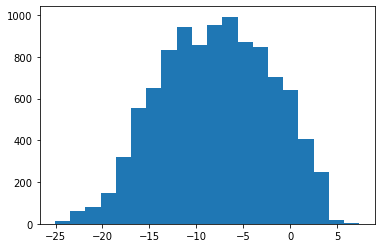

In [15]:
plt.hist(pred_values_sorted, bins = 20)